<a href="https://colab.research.google.com/github/Abudhagir/3D-Vision/blob/main/Pointnet%2B%2B_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PointNet++ Demo**
This code is the implementation of [PointNet++: Deep Hierarchical Feature Learning on Point Sets in a Metric Space](https://proceedings.neurips.cc/paper/2017/file/d8bf84be3800d12f74d8b05e9b89836f-Paper.pdf). We demonstrate the applications of point cloud classification
.

In [1]:
import numpy as np
import math
import random
import os
import torch
from glob import glob
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import plotly.graph_objects as go

In [2]:
!pip install path.py;
!pip install trimesh
from path import Path
import trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.0/681.0 kB 18.5 MB/s eta 0:00:00


In [4]:
#get code
!gdown --id 13KPEBUaqgxXWyKdOoXDvHbFurVXSh8G-

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13KPEBUaqgxXWyKdOoXDvHbFurVXSh8G-
To: /content/Pointnet++.zip
100% 23.4k/23.4k [00:00<00:00, 98.8MB/s]


In [5]:
!unzip Pointnet++.zip

Archive:  Pointnet++.zip
   creating: Pointnet++/
  inflating: Pointnet++/.gitignore   
  inflating: Pointnet++/README.md    
   creating: Pointnet++/data/
  inflating: Pointnet++/data/CustomDataset.py  
  inflating: Pointnet++/data/ModelNet40.py  
  inflating: Pointnet++/data/ShapeNet.py  
 extracting: Pointnet++/data/__init__.py  
  inflating: Pointnet++/data/provider.py  
  inflating: Pointnet++/evaluate.py  
  inflating: Pointnet++/evaluate_custom.py  
   creating: Pointnet++/models/
 extracting: Pointnet++/models/__init__.py  
  inflating: Pointnet++/models/pointnet2_cls.py  
  inflating: Pointnet++/models/pointnet2_seg.py  
  inflating: Pointnet++/train_clss.py  
  inflating: Pointnet++/train_custom_cls.py  
  inflating: Pointnet++/train_part_seg.py  
   creating: Pointnet++/utils/
  inflating: Pointnet++/utils/IoU.py  
 extracting: Pointnet++/utils/__init__.py  
  inflating: Pointnet++/utils/common.py  
  inflating: Pointnet++/utils/feature_propagation.py  
  inflating: Pointnet

In [6]:
%cd Pointnet++

/content/Pointnet++


In [7]:
#get data
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-05-15 11:12:48--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-05-15 11:12:48--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  42.7MB/s    in 11s     

2023-05-15 11:13:00 (40.5 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [8]:
!unzip -q ModelNet10.zip;

In [9]:
classes = ['ceiling', 'floor', 'wall', 'beam', 'column', 'window', 'door', 'table', 'chair', 'sofa', 'bookcase',
           'board', 'clutter']
class2label = {cls: i for i, cls in enumerate(classes)}
seg_classes = class2label
seg_label_to_cat = {}
for i, cat in enumerate(seg_classes.keys()):
    seg_label_to_cat[i] = cat

In [10]:
NUM_CLASSES = 13
BATCH_SIZE = 32
NUM_POINT = 4096

In [11]:
path = Path("ModelNet10")

In [12]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [13]:
pcd = trimesh.load("ModelNet10/sofa/train/sofa_0001.off")

# Data pre-processing

## Sample Points

In [14]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, mesh):
        # sampled_pc = trimesh.sample.sample_surface(mesh,self.output_size)
        # pc = sampled_pc[0]
        points, faces = mesh.sample(self.output_size, return_index=True)
        normals = mesh.face_normals[faces]
        points = np.concatenate((points,normals), axis=1)
        return points

## Normalize

We need to position the point cloud at the center (0,0,0) and the values normalized between 0-1.

In [15]:
class Normalize(object):
    def __call__(self, data ):
        assert len(data.shape)==2
        pointcloud = data[:,:3]
        normals = data[:,3:]

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
        final = np.concatenate((norm_pointcloud, normals),axis=1)
        return  final

## Data Augmentations

We randomly rotate the point cloud and add random noice. 

In [16]:
class RandRotation_z(object):
    def __call__(self, data):
        assert len(data.shape)==2
        pointcloud = data[:,:3]
        normals = data[:,3:]

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        rot_normals = rot_matrix.dot(normals.T).T

        final = np.concatenate((rot_pointcloud, rot_normals),axis=1)

        return  final
    
class RandomNoise_rotate(object):
    def __call__(self, data, angle_sigma=0.06, angle_clip=0.18):
        assert len(data.shape)==2

        pointcloud = data[:,:3]
        normals = data[:,3:]

        angles = np.clip(angle_sigma*np.random.randn(3), -angle_clip, angle_clip)
        Rx = np.array([[1,0,0],
                    [0,np.cos(angles[0]),-np.sin(angles[0])],
                    [0,np.sin(angles[0]),np.cos(angles[0])]])
        Ry = np.array([[np.cos(angles[1]),0,np.sin(angles[1])],
                    [0,1,0],
                    [-np.sin(angles[1]),0,np.cos(angles[1])]])
        Rz = np.array([[np.cos(angles[2]),-np.sin(angles[2]),0],
                    [np.sin(angles[2]),np.cos(angles[2]),0],
                    [0,0,1]])
        R = np.dot(Rz, np.dot(Ry,Rx))

        pointcloud = np.dot(pointcloud, R)
        normals = np.dot(normals, R)

        final = np.concatenate((pointcloud, normals),axis=1)

        return final

## To Tensor

In [17]:
class ToTensor(object):
    def __call__(self, data):
        assert len(data.shape)==2

        pointcloud = data[:,:3]
        normals = data[:,3:]

        pointcloud = torch.from_numpy(pointcloud)
        normals = torch.from_numpy(normals)

        final = np.concatenate((pointcloud, normals),axis=1)

        return final

In [18]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

# Dataset

In [19]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pcd = trimesh.load(file)

        if self.transforms:
            data = self.transforms(pcd)

        pointcloud = data[:,:3]
        normals = data[:,3:]
        
        return pointcloud,normals

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        
        pointcloud,normals = self.__preproc__(pcd_path)
        
        return {'pointcloud': pointcloud, 
                'normals': normals,
                'category': self.classes[category]}

In [20]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise_rotate(),
                    ToTensor()
                    ])

In [21]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [22]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [23]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].shape)
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  (1024, 3)
Class:  bathtub


In [24]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64,drop_last=True)

# Model
Pointnet classification architecture. 
![PointNet.png](https://drive.google.com/uc?id=1wJ-RePRBhkaMoaMVZ8tiTp91a9sa6cy6)


In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from utils.common import gather_points
from utils.grouping import ball_query
from utils.sampling import fps



In [26]:
def sample_and_group(xyz, points, M, radius, K, use_xyz=True):
    '''
    :param xyz: shape=(B, N, 3)
    :param points: shape=(B, N, C)
    :param M: int
    :param radius:float
    :param K: int
    :param use_xyz: bool, if True concat XYZ with local point features, otherwise just use point features
    :return: new_xyz, shape=(B, M, 3); new_points, shape=(B, M, K, C+3);
             group_inds, shape=(B, M, K); grouped_xyz, shape=(B, M, K, 3)
    '''
    new_xyz = gather_points(xyz, fps(xyz, M))
    grouped_inds = ball_query(xyz, new_xyz, radius, K)
    grouped_xyz = gather_points(xyz, grouped_inds)
    grouped_xyz -= torch.unsqueeze(new_xyz, 2).repeat(1, 1, K, 1)
    if points is not None:
        grouped_points = gather_points(points, grouped_inds)
        if use_xyz:
            new_points = torch.cat((grouped_xyz.float(), grouped_points.float()), dim=-1)
        else:
            new_points = grouped_points
    else:
        new_points = grouped_xyz
    return new_xyz, new_points, grouped_inds, grouped_xyz



In [27]:

def sample_and_group_all(xyz, points, use_xyz=True):
    '''
    :param xyz: shape=(B, M, 3)
    :param points: shape=(B, M, C)
    :param use_xyz:
    :return: new_xyz, shape=(B, 1, 3); new_points, shape=(B, 1, M, C+3);
             group_inds, shape=(B, 1, M); grouped_xyz, shape=(B, 1, M, 3)
    '''
    B, M, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C)
    grouped_inds = torch.arange(0, M).long().view(1, 1, M).repeat(B, 1, 1)
    grouped_xyz = xyz.view(B, 1, M, C)
    if points is not None:
        if use_xyz:
            new_points = torch.cat([xyz.float(), points.float()], dim=2)
        else:
            new_points = points
        new_points = torch.unsqueeze(new_points, dim=1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points, grouped_inds, grouped_xyz


In [28]:

class PointNet_SA_Module(nn.Module):
    def __init__(self, M, radius, K, in_channels, mlp, group_all, bn=True, pooling='max', use_xyz=True):
        super(PointNet_SA_Module, self).__init__()
        self.M = M
        self.radius = radius
        self.K = K
        self.in_channels = in_channels
        self.mlp = mlp
        self.group_all = group_all
        self.bn = bn
        self.pooling = pooling
        self.use_xyz = use_xyz
        self.backbone = nn.Sequential()
        for i, out_channels in enumerate(mlp):
            self.backbone.add_module('Conv{}'.format(i),
                                     nn.Conv2d(in_channels, out_channels, 1,
                                               stride=1, padding=0, bias=False))
            if bn:
                self.backbone.add_module('Bn{}'.format(i),
                                         nn.BatchNorm2d(out_channels))
            self.backbone.add_module('Relu{}'.format(i), nn.ReLU())
            in_channels = out_channels
    def forward(self, xyz, points):
        if self.group_all:
            new_xyz, new_points, grouped_inds, grouped_xyz = sample_and_group_all(xyz, points, self.use_xyz)
        else:
            new_xyz, new_points, grouped_inds, grouped_xyz = sample_and_group(xyz=xyz,
                                                                              points=points,
                                                                              M=self.M,
                                                                              radius=self.radius,
                                                                              K=self.K,
                                                                              use_xyz=self.use_xyz)
        new_points = self.backbone(new_points.permute(0, 3, 2, 1).contiguous())
        if self.pooling == 'avg':
            new_points = torch.mean(new_points, dim=2)
        else:
            new_points = torch.max(new_points, dim=2)[0]
        new_points = new_points.permute(0, 2, 1).contiguous()
        return new_xyz, new_points



In [29]:
class pointnet2_cls_ssg(nn.Module):
    def __init__(self, in_channels, nclasses):
        super(pointnet2_cls_ssg, self).__init__()
        self.pt_sa1 = PointNet_SA_Module(M=512, radius=0.2, K=32, in_channels=in_channels, mlp=[64, 64, 128], group_all=False)
        self.pt_sa2 = PointNet_SA_Module(M=128, radius=0.4, K=64, in_channels=131, mlp=[128, 128, 256], group_all=False)
        self.pt_sa3 = PointNet_SA_Module(M=None, radius=None, K=None, in_channels=259, mlp=[256, 512, 1024], group_all=True)
        self.fc1 = nn.Linear(1024, 512, bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.cls = nn.Linear(256, nclasses)

    def forward(self, xyz,points):
        batchsize = xyz.shape[0]
        print("SHAPE", xyz.shape, points.shape)

        new_xyz, new_points = self.pt_sa1(xyz, points)
        new_xyz, new_points = self.pt_sa2(new_xyz, new_points)
        new_xyz, new_points = self.pt_sa3(new_xyz, new_points)
        net = new_points.view(batchsize, -1)
        net = self.dropout1(F.relu(self.bn1(self.fc1(net))))
        net = self.dropout2(F.relu(self.bn2(self.fc2(net))))
        net = self.cls(net)
        return net



In [30]:
class cls_loss(nn.Module):
    def __init__(self):
        super(cls_loss, self).__init__()
        self.loss = nn.CrossEntropyLoss()
    def forward(self, pred, lable):
        '''
        :param pred: shape=(B, nclass)
        :param lable: shape=(B, )
        :return: loss
        '''
        loss = self.loss(pred, lable)
        return loss


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
in_channels = 6
pointnet2 = pointnet2_cls_ssg(in_channels, NUM_CLASSES)
pointnet2.to(device);
loss = cls_loss().to(device)

In [33]:
optimizer = torch.optim.Adam(pointnet2.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

In [34]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet2.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader ):
            
            points, normals, labels = data['pointcloud'].to(device).float(), data['normals'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            pred = pointnet2(points, normals)

            loss_val = loss(pred,labels)
            loss_val.backward()
            optimizer.step()

            # print statistics
            running_loss += loss_val.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet2.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    points, normals, labels = data['pointcloud'].to(device).float(), data['normals'].to(device).float(), data['category'].to(device)
                    outputs =  pointnet2(points, normals)
                    _, predicted = torch.max(outputs , 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet2.state_dict(), "save_"+str(epoch)+".pth")

In [35]:
train(pointnet2, train_loader, valid_loader,  save=True)

SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
[Epoch: 1, Batch:   10 /  124], loss: 2.129
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 3]) torch.Size([32, 1024, 3])
SHAPE torch.Size([32, 1024, 

KeyboardInterrupt: ignored

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
!gdown --id 1VPY_-O9AAxD6BERx1ucQyQ8UJ3nmvvZf

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1VPY_-O9AAxD6BERx1ucQyQ8UJ3nmvvZf
To: /content/Pointnet++/pointnet2_cls.pth
100% 5.91M/5.91M [00:00<00:00, 26.1MB/s]


In [38]:
in_channels = 6
pointnet2 = pointnet2_cls_ssg(in_channels, NUM_CLASSES)
pointnet2.load_state_dict(torch.load('pointnet2_cls.pth',map_location=torch.device('cpu')))
pointnet2.eval();

In [39]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        points, normals, labels = data['pointcloud'].float(), data['normals'].float(), data['category'] 
        outputs =  pointnet2(points, normals)
        _, preds = torch.max(outputs , 1)

        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


Batch [   1 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   2 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   3 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   4 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   5 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   6 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   7 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   8 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [   9 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [  10 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [  11 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [  12 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([64, 1024, 3])
Batch [  13 /   14]
SHAPE torch.Size([64, 1024, 3]) torch.Size([

In [40]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[46,  0,  0,  0,  0,  0,  0,  2,  2,  0],
       [ 0, 84,  1,  0,  0,  0,  0, 14,  1,  0],
       [ 0,  0, 96,  0,  0,  3,  0,  1,  0,  0],
       [ 1,  1,  1, 56,  0,  0,  1,  4, 21,  1],
       [ 1,  1,  0,  1, 68,  0, 12,  0,  1,  2],
       [ 0,  0,  0,  0,  2, 93,  3,  0,  0,  2],
       [ 0,  0,  1,  1, 23,  0, 49,  0, 12,  0],
       [ 0,  2,  1,  0,  0,  2,  1, 94,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 99,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 88]])

In [41]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


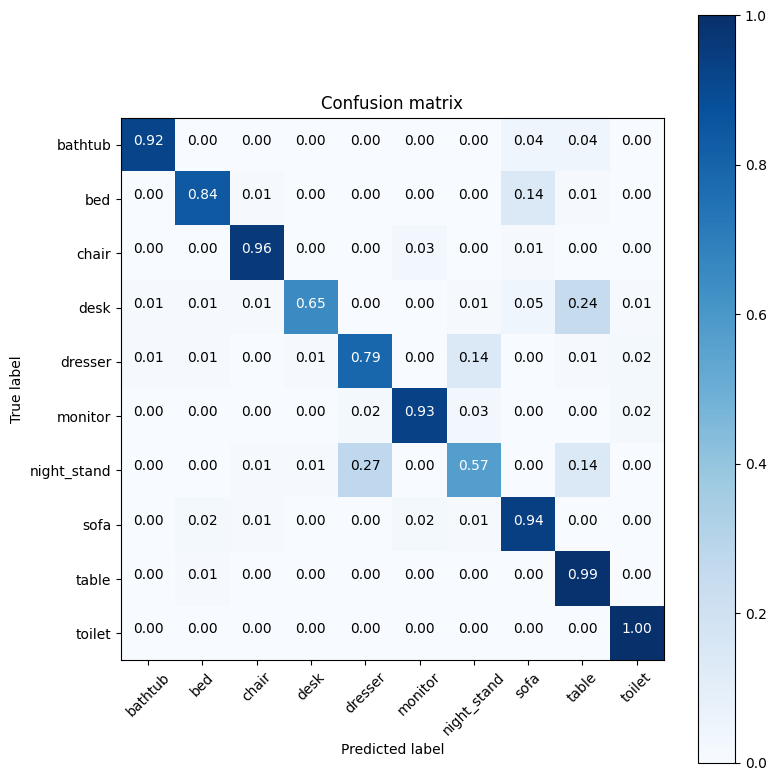

In [42]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


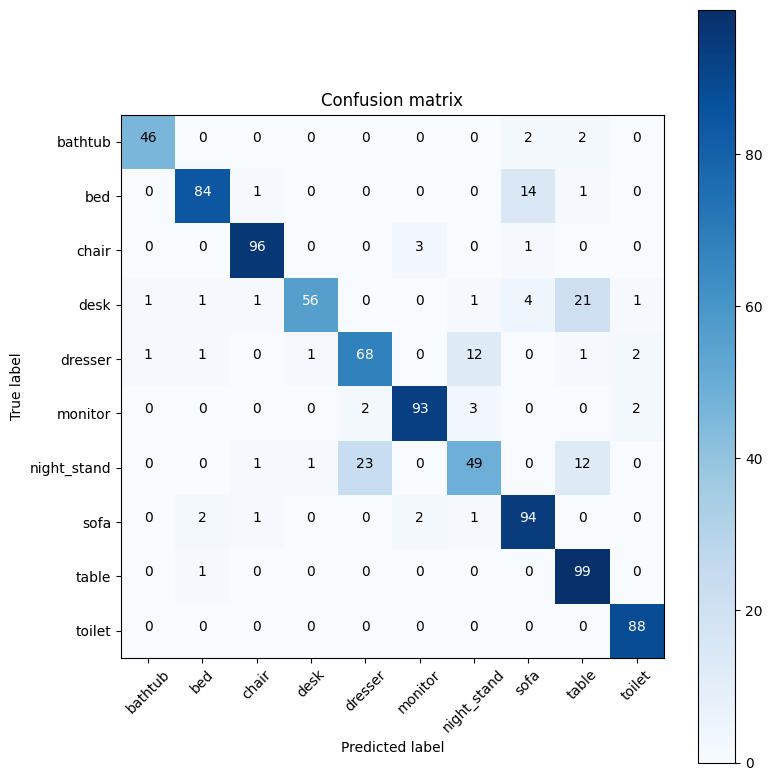

In [43]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)